In [1]:
import catboost

In [2]:
catboost

<module 'catboost' from '/home/noomkcalb/anaconda3/lib/python3.7/site-packages/catboost/__init__.py'>

In [3]:
from lifelines.datasets import load_rossi

In [4]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

In [5]:
rossi_df = load_rossi()

In [6]:
# cph = CoxPHFitter()
# cph.fit(rossi, duration_col='week', event_col='arrest')

In [7]:
# cph.predict_survival_function(rossi)

In [8]:
# cph.predict_survival_function(rossi)[range(10)].plot()

1. Вычислить риск для каждого из пользователей
2. Вычислить знаменатель кумулятивной суммой
3.

In [9]:
import numpy as np
from catboost import Pool, CatBoostRegressor

In [10]:
from time import sleep

In [1557]:
class ProportionalLikelihood(object):
    reg = None
    
    def __init__(self, reg):
        self.reg = reg
        
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True
    
    def set_unique_time(self, t):
        t = t.copy()
        t = t.astype(float)
        for value in np.unique(t):
            t[t == value] += np.arange(t[t == value].shape[0]) / (100 * t[t == value].shape[0])
        return t

    def evaluate(self, h, t, sigma, der1_test=False, loss_test=False):
        t = self.set_unique_time(t)
        N = t.shape[0]
        
        initial_h = h[0] 
        h = np.exp(h[0])
        
        assert np.unique(t).shape[0] == t.shape[0], "All t should be unique"
        
        sorted_h = h[np.argsort(t)]
        cumsum_h = np.cumsum(sorted_h[::-1])[::-1]
        eloss = (sorted_h / cumsum_h)
        
        reg_part = (initial_h ** 2).sum()
        
        loss_sum = -np.log(eloss).sum() + self.reg * reg_part
        
        if loss_test:
            return sorted_h, cumsum_h
        
        if der1_test:
            return loss_sum
        
        return loss_sum, N#np.sum(1 - sigma)#-np.log(loss).sum(), 
    
    def calc_ders_range(self, h, t, sigma, der1_test=False, der2_test=False):
        N = t.shape[0]
        t = self.set_unique_time(t)
        
        initial_h = h
        h = np.exp(h) # Possible math overflow!
        
        sorted_h_indices = np.argsort(t)
        rev_sorted_h_indices = np.argsort(sorted_h_indices)
        
        initial_sorted_h = initial_h[sorted_h_indices]
        sorted_h = h[sorted_h_indices] # hi
        cumsum_h = np.cumsum(sorted_h[::-1])[::-1] #Ci
        
        h_frac = 1 / sorted_h 
        cumsum_h_frac = 1 / cumsum_h 
        cumsum_h_frac_cumsum = np.cumsum(cumsum_h_frac)
        
        der1_part = (cumsum_h_frac_cumsum - h_frac)
        
        der1 = der1_part * sorted_h + 2 * self.reg * initial_sorted_h
        
        if der1_test:
            print(der1)
            return der1[rev_sorted_h_indices]
        
        h_frac_square = 1 / (sorted_h ** 2)
        cumsum_h_frac_square = 1 / (cumsum_h ** 2)
        cumsum_h_frac_square_cumsum = np.cumsum(cumsum_h_frac_square)
        
        der2_part = h_frac_square - cumsum_h_frac_square_cumsum
        
        der2 = sorted_h * (der1_part + der2_part * sorted_h) + self.reg * 2 * np.sign(initial_sorted_h)
        
        if der2_test:
            return der2[rev_sorted_h_indices]
        
        # TODO replace with np.stack
        result = []
        
        for i in rev_sorted_h_indices:
            result.append((
                -der1[i],
                -der2[i]
            ))
        return result

- Ошибка на неотсортированном массиве
- Производная не сонаправлена

In [1558]:
loss = ProportionalLikelihood(reg=0)

In [1559]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(6.015889833080853, 3)

In [1560]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([2, 3, 8]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(11.015889833080852, 3)

In [1561]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([1, 2, 3]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(11.015889833080852, 3)

In [1562]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([1, 0, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)

11.011650169729464

In [1563]:
delta = 0.001

In [1564]:
# # First derivative, i=1
((loss.evaluate(
    (np.array([2 + delta, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)

-0.9975261843937488

In [1565]:
# First derivative, i=2
((loss.evaluate(
    (np.array([2, -3 + delta, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)


3.337823439863996e-05

In [1566]:
# First derivative, i=3
((loss.evaluate(
    (np.array([2, -3, 8 + delta]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)


0.9974953059481706

In [1567]:
loss.calc_ders_range(
    np.array([2, -3, 8]), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)

[-9.97527418e-01  9.97494056e-01  3.33615481e-05]


array([-9.97527418e-01,  3.33615481e-05,  9.97494056e-01])

In [1568]:
# Second derivative, i = 1
(
    loss.calc_ders_range(
        np.array([2 + delta, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[0] / delta

[-0.99752495 -0.99996664  1.99749159]
[-0.99752742 -0.99996664  1.99749406]


0.002467695841779083

In [1569]:
# Second derivative, i = 2
(
    loss.calc_ders_range(
        np.array([2, -3 + delta, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[1] / delta

[-0.99752742 -0.99996661  1.99749402]
[-0.99752742 -0.99996664  1.99749406]


3.33776771777039e-05

In [1570]:
# Second derivative, i = 3
(
    loss.calc_ders_range(
        np.array([2, -3, 8 + delta]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[2] / delta

[-0.99752988 -0.99996667  1.99749655]
[-0.99752742 -0.99996664  1.99749406]


0.0024985036235491975

In [1571]:
loss.calc_ders_range(
    np.array([2, -3, 8]), 
    np.array([0, 1, 2]), 
    np.array([0, 0, 0]),
    der2_test=True
)

array([2.46646830e-03, 3.33609916e-05, 2.49974691e-03])

# Difficult cases

In [1572]:
# test_t = np.array([20, 17, 25, 23, 37, 25, 46, 28, 24, 50])
# test_h = np.array([ 1.0579772  , 1.3556235 ,  1.59537611 , 0.42585979 , 1.44649814 , 0.5426282,
#  -2.33794021,  0.20124088, -0.42943875, -1.66655973])

test_t = np.array([20, 17, 25, 23, 37, 25.1, 46, 28])
test_h = np.array([ 1.0579772  , 1.3556235 ,  1.59537611 , 0.42585979 , 1.44649814 , 0.5426282,
 -2.33794021,  0.20124088])
test_sigma = np.zeros(test_t.shape[0])

In [1573]:
np.argsort(test_t)

array([1, 0, 3, 2, 5, 7, 4, 6])

In [1574]:
def get_numeric_derivative(h, t, sigma, i):
    h_increased = h.copy()
    h_increased[i] += delta
    
    return ((loss.evaluate(
        (h_increased, ), 
        t, 
        sigma,
        der1_test=True
    ) - loss.evaluate(
        (h, ), 
        t, 
        sigma,
        der1_test=True
    )) / delta)

In [1575]:
np.array([get_numeric_derivative(test_h, test_t, test_sigma, i) for i in range(test_h.shape[0])])

array([-0.68620013, -0.81077798,  0.2993728 , -0.72182604,  2.44357478,
       -0.31033801,  0.07826807, -0.29005566])

In [1576]:
loss.calc_ders_range(
    test_h, 
    test_t, 
    test_sigma,
#     der1_test=True
)

[(0.6863321308544819, -0.2639374000006037),
 (0.8108546772870494, -0.15336936960876438),
 (-0.29894181575348516, -0.8618661950087438),
 (0.7219518750410215, -0.2516038809095025),
 (-2.4429545443251746, -1.2404186627387026),
 (0.31062827965981954, -0.5804131636993918),
 (-0.07822950756005731, -0.07709239984216013),
 (0.29035890479634446, -0.6063489768899988)]

# Model

In [1586]:
model = CatBoostRegressor(
    loss_function=loss, 
    eval_metric=loss, 
    iterations=1000, 
    learning_rate=0.01
)

In [1587]:
N = 10000

In [1588]:
rossi2_df = rossi_df[rossi_df['week'] < 52].iloc[0:N].reset_index(drop=True)

In [1589]:
X = rossi2_df

In [1590]:
t = rossi2_df['week']

In [1591]:
sigma = rossi2_df['arrest']

In [1592]:
import numba

In [1593]:
import matplotlib.pyplot as plt

/home/noomkcalb/anaconda3/lib/python3.7/site-packages/catboost/core.py:1913: UserWarning: Can't optimze method "calc_ders_range" because self argument is used
  _check_train_params(params)


0:	learn: 409.4974937	total: 3.17ms	remaining: 3.17s
1:	learn: 408.8500053	total: 6.39ms	remaining: 3.19s
2:	learn: 408.3693797	total: 9.44ms	remaining: 3.14s
3:	learn: 407.6997825	total: 12.3ms	remaining: 3.07s
4:	learn: 406.9972123	total: 16.1ms	remaining: 3.2s
5:	learn: 406.0462055	total: 18.9ms	remaining: 3.12s
6:	learn: 405.3921655	total: 21.9ms	remaining: 3.11s
7:	learn: 404.7644011	total: 25ms	remaining: 3.1s
8:	learn: 404.2785802	total: 28ms	remaining: 3.08s
9:	learn: 403.7416934	total: 30.8ms	remaining: 3.05s
10:	learn: 402.9179093	total: 33.9ms	remaining: 3.05s
11:	learn: 402.2633693	total: 36.6ms	remaining: 3.01s
12:	learn: 401.6632253	total: 39.2ms	remaining: 2.98s
13:	learn: 400.9452518	total: 42.2ms	remaining: 2.97s
14:	learn: 400.5639764	total: 45ms	remaining: 2.96s
15:	learn: 399.9398258	total: 47.7ms	remaining: 2.93s
16:	learn: 399.2953752	total: 50.4ms	remaining: 2.91s
17:	learn: 398.8485209	total: 53.2ms	remaining: 2.9s
18:	learn: 398.0935897	total: 55.9ms	remaining:

202:	learn: 332.4769855	total: 592ms	remaining: 2.32s
203:	learn: 332.3282862	total: 596ms	remaining: 2.32s
204:	learn: 332.1126992	total: 599ms	remaining: 2.32s
205:	learn: 331.9033358	total: 602ms	remaining: 2.32s
206:	learn: 331.6552734	total: 605ms	remaining: 2.32s
207:	learn: 331.3690836	total: 609ms	remaining: 2.32s
208:	learn: 331.1164134	total: 616ms	remaining: 2.33s
209:	learn: 330.8457359	total: 620ms	remaining: 2.33s
210:	learn: 330.5945720	total: 623ms	remaining: 2.33s
211:	learn: 330.3699355	total: 626ms	remaining: 2.33s
212:	learn: 330.1294285	total: 629ms	remaining: 2.32s
213:	learn: 329.9070392	total: 632ms	remaining: 2.32s
214:	learn: 329.7539546	total: 635ms	remaining: 2.32s
215:	learn: 329.5055781	total: 637ms	remaining: 2.31s
216:	learn: 329.3401926	total: 641ms	remaining: 2.31s
217:	learn: 329.2090972	total: 643ms	remaining: 2.31s
218:	learn: 328.9277283	total: 646ms	remaining: 2.31s
219:	learn: 328.7332693	total: 649ms	remaining: 2.3s
220:	learn: 328.5139968	total

395:	learn: 298.5620179	total: 1.18s	remaining: 1.8s
396:	learn: 298.3894321	total: 1.18s	remaining: 1.79s
397:	learn: 298.2707797	total: 1.18s	remaining: 1.79s
398:	learn: 298.1354766	total: 1.19s	remaining: 1.79s
399:	learn: 298.0130628	total: 1.19s	remaining: 1.79s
400:	learn: 297.8585846	total: 1.19s	remaining: 1.78s
401:	learn: 297.7416435	total: 1.2s	remaining: 1.78s
402:	learn: 297.5995264	total: 1.2s	remaining: 1.78s
403:	learn: 297.4496764	total: 1.2s	remaining: 1.77s
404:	learn: 297.3289141	total: 1.21s	remaining: 1.77s
405:	learn: 297.1860065	total: 1.21s	remaining: 1.77s
406:	learn: 297.0635361	total: 1.21s	remaining: 1.76s
407:	learn: 296.9425225	total: 1.21s	remaining: 1.76s
408:	learn: 296.7973647	total: 1.22s	remaining: 1.76s
409:	learn: 296.6685062	total: 1.22s	remaining: 1.76s
410:	learn: 296.5404022	total: 1.22s	remaining: 1.75s
411:	learn: 296.4094452	total: 1.23s	remaining: 1.75s
412:	learn: 296.2693895	total: 1.23s	remaining: 1.75s
413:	learn: 296.1588619	total: 1

588:	learn: 275.9194773	total: 1.76s	remaining: 1.23s
589:	learn: 275.8046293	total: 1.77s	remaining: 1.23s
590:	learn: 275.6902923	total: 1.77s	remaining: 1.22s
591:	learn: 275.5894870	total: 1.77s	remaining: 1.22s
592:	learn: 275.4931122	total: 1.77s	remaining: 1.22s
593:	learn: 275.3885203	total: 1.78s	remaining: 1.22s
594:	learn: 275.2792600	total: 1.78s	remaining: 1.21s
595:	learn: 275.1800580	total: 1.78s	remaining: 1.21s
596:	learn: 275.0639690	total: 1.79s	remaining: 1.21s
597:	learn: 274.9750533	total: 1.79s	remaining: 1.2s
598:	learn: 274.8658693	total: 1.79s	remaining: 1.2s
599:	learn: 274.7818631	total: 1.79s	remaining: 1.2s
600:	learn: 274.6754315	total: 1.8s	remaining: 1.19s
601:	learn: 274.5909408	total: 1.81s	remaining: 1.2s
602:	learn: 274.4967453	total: 1.81s	remaining: 1.19s
603:	learn: 274.3876800	total: 1.81s	remaining: 1.19s
604:	learn: 274.2617323	total: 1.82s	remaining: 1.19s
605:	learn: 274.1830532	total: 1.82s	remaining: 1.18s
606:	learn: 274.0991120	total: 1.

778:	learn: 258.5133421	total: 2.35s	remaining: 667ms
779:	learn: 258.4279670	total: 2.35s	remaining: 664ms
780:	learn: 258.3359049	total: 2.36s	remaining: 661ms
781:	learn: 258.2481984	total: 2.36s	remaining: 658ms
782:	learn: 258.1651376	total: 2.36s	remaining: 655ms
783:	learn: 258.0759015	total: 2.37s	remaining: 652ms
784:	learn: 258.0034857	total: 2.37s	remaining: 649ms
785:	learn: 257.9359553	total: 2.37s	remaining: 646ms
786:	learn: 257.8606282	total: 2.38s	remaining: 643ms
787:	learn: 257.7736639	total: 2.38s	remaining: 640ms
788:	learn: 257.6902662	total: 2.38s	remaining: 637ms
789:	learn: 257.6225069	total: 2.38s	remaining: 634ms
790:	learn: 257.5343532	total: 2.39s	remaining: 631ms
791:	learn: 257.4622229	total: 2.39s	remaining: 628ms
792:	learn: 257.3961172	total: 2.39s	remaining: 625ms
793:	learn: 257.3150618	total: 2.4s	remaining: 622ms
794:	learn: 257.2253137	total: 2.4s	remaining: 619ms
795:	learn: 257.1605658	total: 2.4s	remaining: 616ms
796:	learn: 257.0846357	total: 

970:	learn: 244.6922777	total: 2.94s	remaining: 87.9ms
971:	learn: 244.6242369	total: 2.95s	remaining: 84.9ms
972:	learn: 244.5713838	total: 2.95s	remaining: 81.9ms
973:	learn: 244.5107254	total: 2.95s	remaining: 78.9ms
974:	learn: 244.4509556	total: 2.96s	remaining: 75.9ms
975:	learn: 244.3900230	total: 2.96s	remaining: 72.8ms
976:	learn: 244.3246477	total: 2.96s	remaining: 69.8ms
977:	learn: 244.2575547	total: 2.97s	remaining: 66.7ms
978:	learn: 244.1993742	total: 2.97s	remaining: 63.7ms
979:	learn: 244.1319632	total: 2.97s	remaining: 60.7ms
980:	learn: 244.0647069	total: 2.98s	remaining: 57.6ms
981:	learn: 244.0036094	total: 2.98s	remaining: 54.6ms
982:	learn: 243.9419330	total: 2.98s	remaining: 51.6ms
983:	learn: 243.8802694	total: 2.98s	remaining: 48.5ms
984:	learn: 243.8160530	total: 2.99s	remaining: 45.6ms
985:	learn: 243.7511430	total: 3s	remaining: 42.6ms
986:	learn: 243.6916824	total: 3s	remaining: 39.6ms
987:	learn: 243.6301421	total: 3.01s	remaining: 36.5ms
988:	learn: 243.

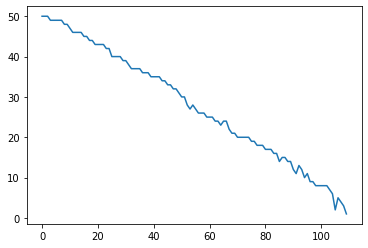

In [1594]:
for i in range(0, 1):
    if i == 0:
        model.fit(X, t, sample_weight=sigma, verbose_eval=True)
    else:
        model.fit(X, t, sample_weight=sigma, verbose_eval=True, init_model=model)
    prediction = model.predict(X)
    
    print(t.values, prediction)
    
    t[np.argsort(prediction)].reset_index(drop=True).plot()
    plt.show()